In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats

# Load datasets
ds = xr.open_dataset("GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02CRI.nc")
# catalog = pd.read_csv('eq_200204_202102.csv')
# catalog["time"] = catalog["time"].astype("datetime64")
catalog = pd.read_csv('etas/ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

In [2]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data
  
catalog['dmass'] = catalog.apply(lambda row: get_mass(row), axis=1)

In [3]:
catalog['on_land'] = globe.is_land(catalog.latitude, catalog.longitude)

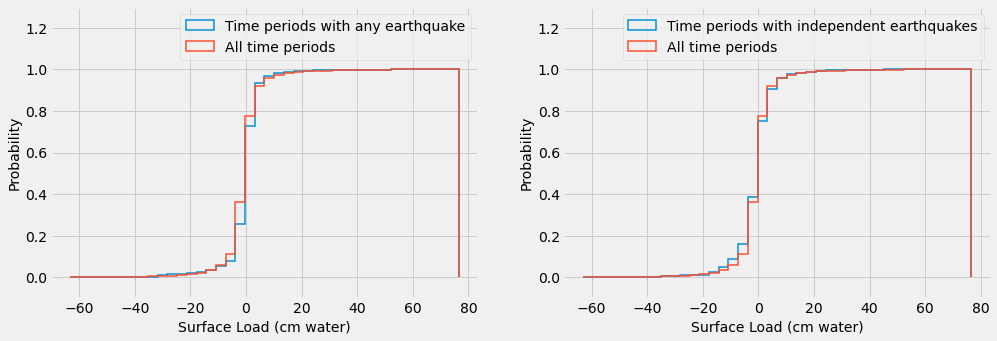

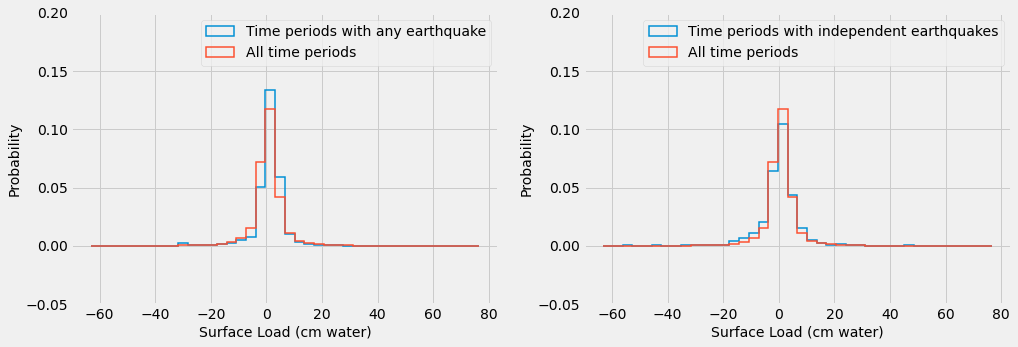

In [10]:
# Plot the distributions
plt.style.use('fivethirtyeight')
bins = np.histogram(catalog['dmass'], 40)[1]
fig,ax = plt.subplots(1, 2, figsize=(15,5))
ax = plt.subplot(1,2,1)
ax.hist(np.array(catalog['dmass']), bins, density = True, cumulative=True, histtype='step',
            label='Time periods with any earthquake',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=True,histtype='step',
            label='All time periods',linewidth=1.5)
plt.xlabel('Surface Load (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
# ax.set_ylim((1e-5,5))
ax.set_ylim((-0.1,1.3))
# ax.set_yscale('log')
ax.legend()

ax = plt.subplot(1,2,2)
ax.hist(catalog[catalog['P_triggered'] < 0.9]['dmass'], bins, cumulative=True, histtype='step',
        density = True, label='Time periods with independent earthquakes',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=True,histtype='step',
             label='All time periods',linewidth=1.5)
# plt.xlim((-100,100))
ax.set_ylim((-0.1,1.3))
# ax.set_yscale('log')
plt.xlabel('Surface Load (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
ax.legend()
plt.show()






bins = np.histogram(catalog['dmass'], 40)[1]
fig,ax = plt.subplots(1, 2, figsize=(15,5))
ax = plt.subplot(1,2,1)
ax.hist(np.array(catalog['dmass']), bins, density = True, cumulative=False, histtype='step',
            label='Time periods with any earthquake',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=False,histtype='step',
            label='All time periods',linewidth=1.5)
plt.xlabel('Surface Load (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
# ax.set_ylim((1e-5,5))
ax.set_ylim((-0.05,0.2))
# ax.set_yscale('log')
ax.legend()

ax = plt.subplot(1,2,2)
ax.hist(catalog[catalog['P_triggered'] < 0.9]['dmass'], bins, cumulative=False, histtype='step',
        density = True, label='Time periods with independent earthquakes',linewidth=1.5)
ax.hist(ds['lwe_thickness'].data.flatten(), bins, density = True, cumulative=False,histtype='step',
             label='All time periods',linewidth=1.5)
# plt.xlim((-100,100))
ax.set_ylim((-0.05,0.2))
# ax.set_yscale('log')
plt.xlabel('Surface Load (cm water)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
ax.legend()
plt.show()

In [7]:
# What is the probability that the two results are the same?
# if p-value < significance level, reject that samples are from same distribution




# a = np.array(catalog[catalog['P_triggered'] < 0.9]['dmass'])
# b = np.array(ds['lwe_thickness'].data.flatten())
# stats.ks_2samp(a,b, mode='asymp')
# output: KstestResult(statistic=0.04963563191122192, pvalue=0.1566585634353047)

# a = np.array(catalog.dmass)
# b =  np.array(ds['lwe_thickness'].data.flatten())
# stats.ks_2samp(, d, mode='asymp')
# output: KstestResult(statistic=0.12212035878155786, pvalue=2.4886704147936648e-123)

KstestResult(statistic=0.12212035878155786, pvalue=2.4886704147936648e-123)

In [11]:
a = np.array(catalog.dmass)
b =  np.array(ds['lwe_thickness'].data.flatten())
stats.cramervonmises_2samp(a, b, method='auto')

CramerVonMisesResult(statistic=60.854618746814594, pvalue=9.69405278272717e-09)

In [12]:
a = np.array(catalog[catalog['P_triggered'] < 0.9]['dmass'])
b =  np.array(ds['lwe_thickness'].data.flatten())
stats.cramervonmises_2samp(a, b, method='auto')

CramerVonMisesResult(statistic=18.54565601407802, pvalue=3.6608838183127546e-09)

In [16]:
np.median(catalog[catalog['P_triggered'] < 0.9]['dmass'])

0.6096533443654473

In [15]:
np.median(ds['lwe_thickness'].data.flatten())

0.6627782418257632

In [17]:
np.median(np.array(catalog.dmass))

1.425528633547053

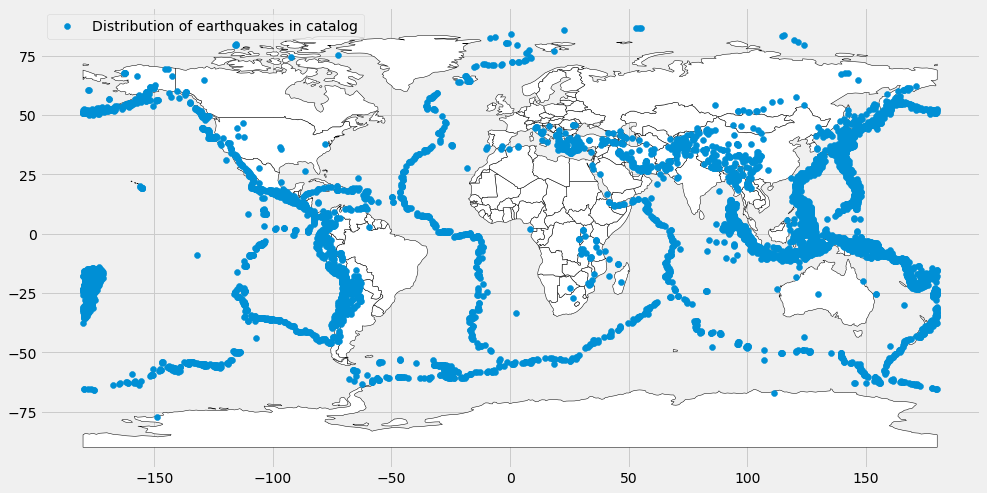

In [20]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(catalog.longitude, catalog.latitude))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(color='white', edgecolor='black', figsize=(8,6))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax, label='Distribution of earthquakes in catalog')
leg = ax.legend()

# gdi = gpd.GeoDataFrame(df_ind, geometry=gpd.points_from_xy(df_ind.longitude, df_ind.latitude))
# gdi.plot(ax=ax, markersize = 5)

# plt.show()

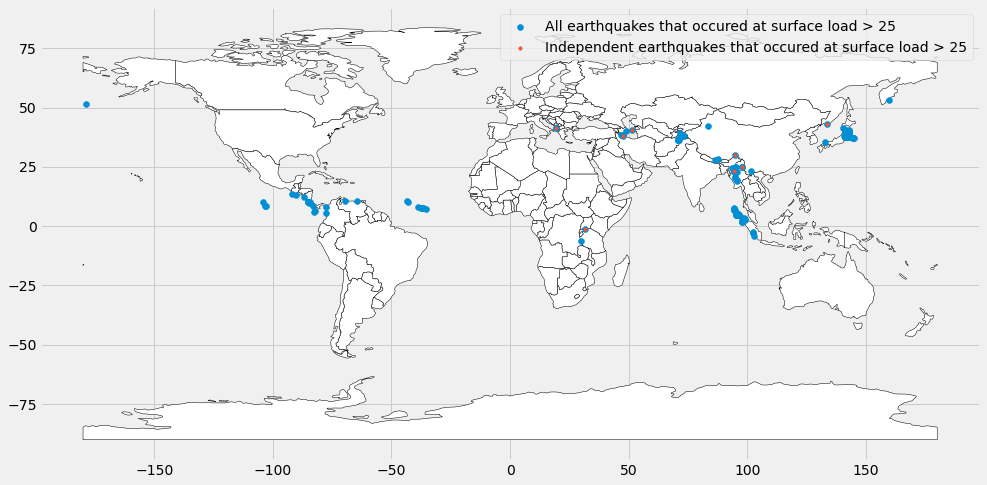

In [21]:
thr = 25
df_bigmass = catalog[np.abs(catalog['dmass']) > thr]
gdf = gpd.GeoDataFrame(df_bigmass,
                       geometry=gpd.points_from_xy(df_bigmass.longitude, 
                                                   df_bigmass.latitude))

df_bigmass_ind = catalog[(np.abs(catalog['dmass']) > thr) & (catalog['P_triggered'] < 0.9)]
gdi = gpd.GeoDataFrame(df_bigmass_ind,
                       geometry=gpd.points_from_xy(df_bigmass_ind.longitude, 
                                                   df_bigmass_ind.latitude))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax, label='All earthquakes that occured at surface load > 25')
gdi.plot(ax=ax, markersize = 12, label = 'Independent earthquakes that occured at surface load > 25')
leg = ax.legend()
plt.show()

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(color='white', edgecolor='black', figsize=(8,6))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax)
gdi.plot(ax=ax, markersize = 10)
ax.set_xlim((25,180))
ax.set_ylim((0,50))
plt.show()

In [ ]:
catalog

In [ ]:
catalog['dmass']

In [ ]:
len(ds['lwe_thickness'])